In [40]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn
# !pip install ucimlrepo

# Task 1. Algorithm's analysis

In [41]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

import time
from tqdm import tqdm

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt
import heapq # for optimized Prim's cuz it's slow otherwise

### Generating graph

In [42]:

# You can use this function to generate a random graph with 'num_of_nodes'
# nodes and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False,
                               custom_weights = [-5, 20]):
    """
    Generates a random graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted
    (in case of undirected graphs)
    """


    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))

    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)

    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(custom_weights[0], custom_weights[1])

    if draw:
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue',
                    with_labels=True,
                    node_size=500,
                    arrowsize=20,
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)

        else:
            nx.draw(G, node_color='lightblue',
                with_labels=True,
                node_size=500)

    return G

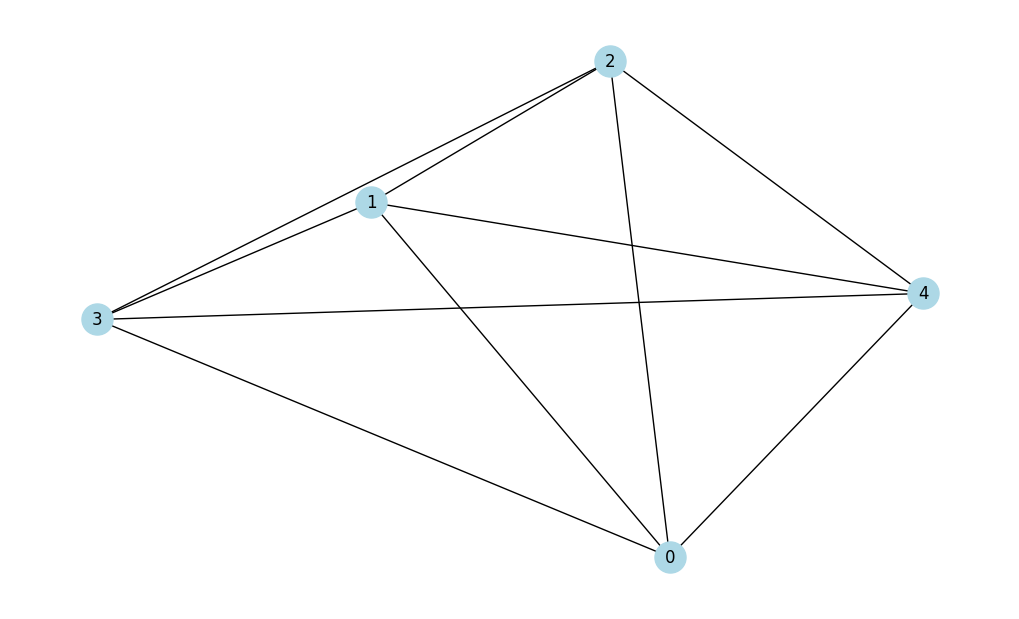

In [43]:
G = gnp_random_connected_graph(5, 1, False, True)

## Subtask 1.1 (1 point)

### Kruskal's algorithm

#### nx implementation

In [44]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

#### Your implementation

In [45]:
class DSU:
    def __init__(self, size):
        self.parent = list(range(size))
        self.rank = [0] * size

    def find(self, i):
        if self.parent[i] != i:
            self.parent[i] = self.find(self.parent[i])
        return self.parent[i]

    def unite(self, i, j):
        parentI = self.find(i)
        parentJ = self.find(j)

        if parentI == parentJ:
            return False # цикл, бо i й j в одному сеті

        if self.rank[parentI] < self.rank[parentJ]:
            self.parent[parentI] = parentJ
        elif self.rank[parentI] > self.rank[parentJ]:
            self.parent[parentJ] = parentI
        else:
            self.parent[parentJ] = parentI
            self.rank[parentI] += 1

        return True

In [46]:
# KRUSK
def Kruskal(graph: nx.Graph):
    if type(graph) == nx.DiGraph:
        raise Exception("Kruskal does not work for directed graphs.")
    edges = []

    for u, v, data in graph.edges(data=True):
        w = data.get("weight", 0)
        edges.append((u,v,w))
    edges.sort(key=lambda x: x[2])

    nodes_count = graph.number_of_nodes()

    disjoin_set = DSU(nodes_count)

    mst = []

    for u, v, w in edges:
        if disjoin_set.unite(u, v):
            mst.append((u,v,w))
    return mst

#### Additional point (+0.5)

Use DSU (disjoint set union) in implementation of the algorithm 

## DONE

### Prim's algorithm

#### nx implementation

In [47]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

#### Your implementation

In [48]:

def Prim(graph: nx.Graph):
    adjacent_to = {node: [] for node in graph.nodes()}

    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 0)
        adjacent_to[u].append((v, weight))
        adjacent_to[v].append((u, weight))

    starting_point = list(adjacent_to.keys())[0]

    visited = {starting_point}

    mst = []

    heapm = []

    # adding the initial edges into the heap to start the proces
    for neighbor, weight in adjacent_to[starting_point]:
        heapq.heappush(heapm, (weight, starting_point, neighbor))

    # stops when n-1 edges have been added
    max_edges = len(adjacent_to) - 1

    while heapm and len(mst) < max_edges:
        w, u, v = heapq.heappop(heapm)

        if v in visited:
            continue

        visited.add(v)
        mst.append((u,v,w))

        for neighbor, weight in adjacent_to[v]:
            if neighbor not in visited:
                heapq.heappush(heapm, (weight, v, neighbor))

    return mst


# TESTING

NX Kruskal N=200: 100%|██████████| 100/100 [00:02<00:00, 44.20it/s]


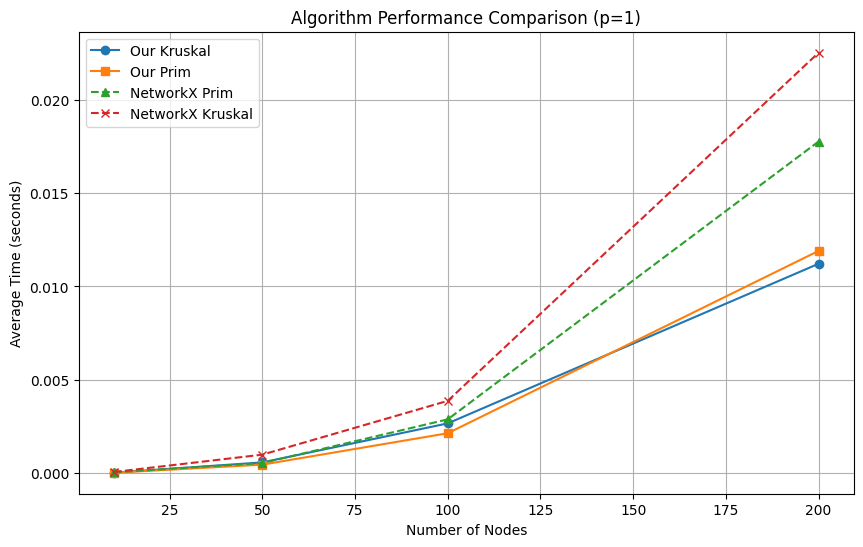

In [49]:
NODES = [10, 50, 100, 200]
COMPLETENESS = 1
NUM_OF_ITERATIONS = 100
results = []

for N in NODES:
    G = gnp_random_connected_graph(N, COMPLETENESS, False)

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"Kruskal N={N}"):
        start = time.time()
        Kruskal(G)
        end = time.time()
        time_taken += end - start
    avg_kruskal = time_taken / NUM_OF_ITERATIONS

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"Prim N={N}"):
        start = time.time()
        Prim(G)
        end = time.time()
        time_taken += end - start
    arv_prim = time_taken / NUM_OF_ITERATIONS

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"NX Prim N={N}"):
        start = time.time()
        tree.minimum_spanning_tree(G, algorithm="prim")
        end = time.time()
        time_taken += end - start
    avr_nx_prim = time_taken / NUM_OF_ITERATIONS

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"NX Kruskal N={N}"):
        start = time.time()
        tree.minimum_spanning_tree(G, algorithm="kruskal")
        end = time.time()
        time_taken += end - start
    avr_nx_kruskal = time_taken / NUM_OF_ITERATIONS

    results.append({
        'Nodes': N,
        'Our Kruskal': avg_kruskal,
        'Our Prim': arv_prim,
        'NX Prim': avr_nx_prim,
        'NX Kruskal': avr_nx_kruskal
    })

df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df['Nodes'], df['Our Kruskal'], marker='o', label='Our Kruskal')
plt.plot(df['Nodes'], df['Our Prim'], marker='s', label='Our Prim')
plt.plot(df['Nodes'], df['NX Prim'], marker='^', linestyle='--', label='NetworkX Prim')
plt.plot(df['Nodes'], df['NX Kruskal'], marker='x', linestyle='--', label='NetworkX Kruskal')

plt.title(f"Algorithm Performance Comparison (p={COMPLETENESS})")
plt.xlabel("Number of Nodes")
plt.ylabel("Average Time (seconds)")
plt.legend()
plt.grid(True)
plt.show()

Тестування проводилось на повних графах (completeness = 1), де кількість ребер $E \approx V^2$ (щільний граф).1. 

Швидшим для великих графів виявився крускал

NX Kruskal N=200: 100%|██████████| 100/100 [00:01<00:00, 91.26it/s]


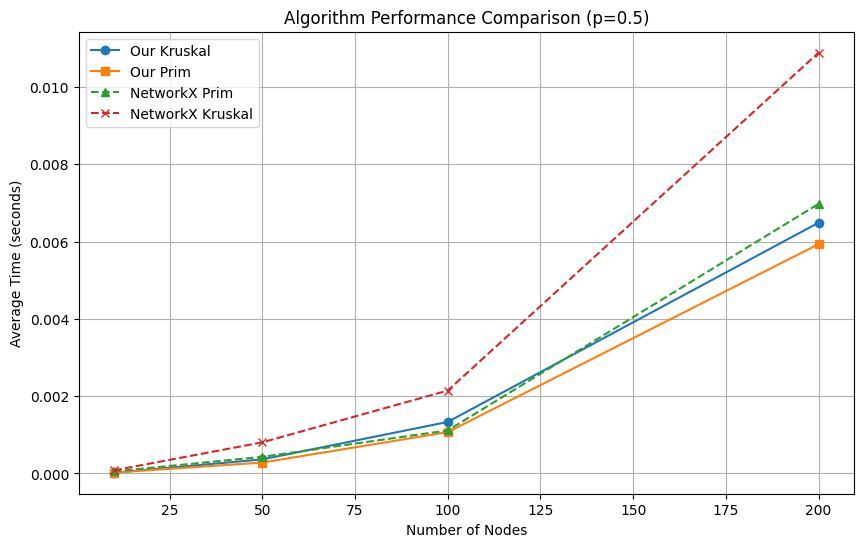

In [50]:
NODES = [10, 50, 100, 200]
COMPLETENESS = 0.5
NUM_OF_ITERATIONS = 100
results = []

for N in NODES:
    G = gnp_random_connected_graph(N, COMPLETENESS, False)

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"Kruskal N={N}"):
        start = time.time()
        Kruskal(G)
        end = time.time()
        time_taken += end - start
    avg_kruskal = time_taken / NUM_OF_ITERATIONS

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"Prim N={N}"):
        start = time.time()
        Prim(G)
        end = time.time()
        time_taken += end - start
    arv_prim = time_taken / NUM_OF_ITERATIONS

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"NX Prim N={N}"):
        start = time.time()
        tree.minimum_spanning_tree(G, algorithm="prim")
        end = time.time()
        time_taken += end - start
    avr_nx_prim = time_taken / NUM_OF_ITERATIONS

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"NX Kruskal N={N}"):
        start = time.time()
        tree.minimum_spanning_tree(G, algorithm="kruskal")
        end = time.time()
        time_taken += end - start
    avr_nx_kruskal = time_taken / NUM_OF_ITERATIONS

    results.append({
        'Nodes': N,
        'Our Kruskal': avg_kruskal,
        'Our Prim': arv_prim,
        'NX Prim': avr_nx_prim,
        'NX Kruskal': avr_nx_kruskal
    })

df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df['Nodes'], df['Our Kruskal'], marker='o', label='Our Kruskal')
plt.plot(df['Nodes'], df['Our Prim'], marker='s', label='Our Prim')
plt.plot(df['Nodes'], df['NX Prim'], marker='^', linestyle='--', label='NetworkX Prim')
plt.plot(df['Nodes'], df['NX Kruskal'], marker='x', linestyle='--', label='NetworkX Kruskal')

plt.title(f"Algorithm Performance Comparison (p={COMPLETENESS})")
plt.xlabel("Number of Nodes")
plt.ylabel("Average Time (seconds)")
plt.legend()
plt.grid(True)
plt.show()

Тестування проводилось на графах середньої щільності (completeness = 0.5), де кількість ребер значно менша, ніж у повних графах.

Тепер швидшим виявився алгоритм Прима

### Загальний підсумок

Алгоритм Крускала працює найкраще на щільних/повних графах ($p \approx 1$) 
Попри те, що теоретично алгоритм Прима часто вважається ефективнішим для щільних графів ($O(V^2)$) алгоритм Крускала виявився швидшим. Основна складність Крускала — сортування ребер. У Python вбудоване сортування (Timsort) реалізоване на C і є швидким. Натомість реалізація Прима використовує heapq всередині циклу while на чистому Python. У повному графі черга заповнюється величезною кількістю ребер, і накладні витрати інтерпретатора на постійні операції push/pop перевищують виграш від алгоритмічної логіки.

Алгоритм Прима працює найкраще на розріджених графах ($p \le 0.5$)
Алгоритм Крускала змушений сортувати весь список ребер ($O(E \log E)$) на самому початку, і при $p=0.5$ цей список все ще досить великий, що створює значну затримку перед початком роботи. Натомість алгоритм Прима працює локально: зменшення щільності графа вдвічі означає, що у кожної вершини вдвічі менше сусідів. Це суттєво розвантажує чергу пріоритетів (heap), пришвидшуючи операції push/pop на кожній ітерації.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# Subtask 1.2 (1 point)

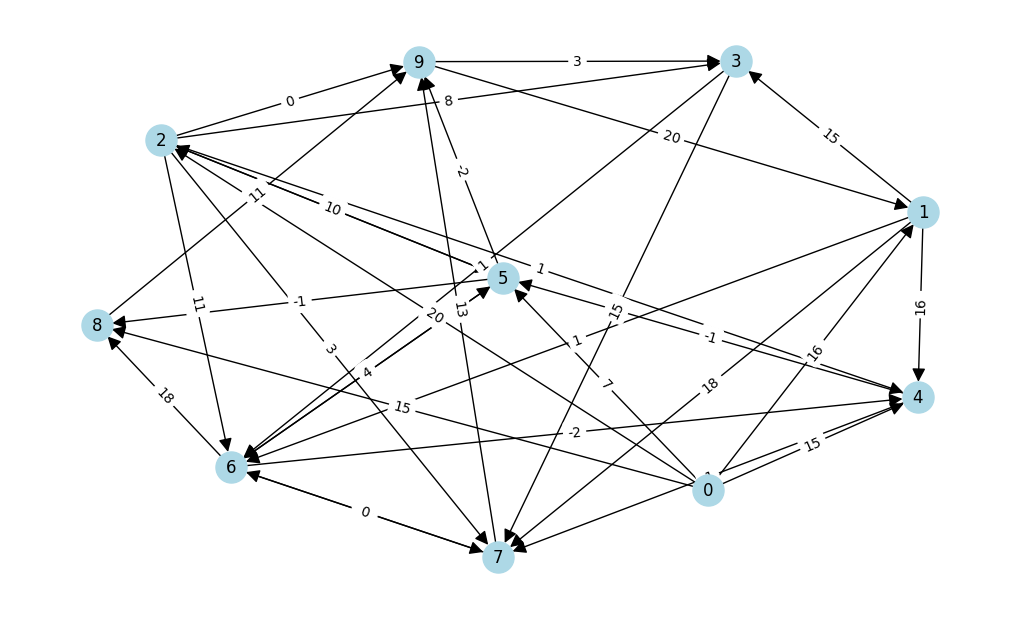

In [51]:
G2 = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

#### nx implementation

In [52]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G2, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Negative cycle detected


#### Your implementation

In [ ]:
def Belford(graph: nx.DiGraph | nx.Graph, source):
    distances = {node: float('inf') for node in graph.nodes}
    predecessors = {node: None for node in graph.nodes}

    distances[source] = 0

    edges = [ ]
    for u, v, weight_data in graph.edges(data=True):
        weight = weight_data.get('weight', 0)
        edges.append((u,v,weight))
        if not graph.is_directed():
            edges.append((v,u,weight))

    # реалаксація
    for _ in range(graph.number_of_nodes() - 1):
        chnges = False
        for u, v, w in edges:
            if distances[u] != float("inf") \
                and distances[u] + w < distances[v]:
                    distances[v] = distances[u] + w
                    predecessors[v] = u
                    chnges = True
        if not chnges:
            break

    for u, v, w in edges:
        if distances[u] != float("inf") \
            and distances[u] + w < distances[v]:
                raise Exception("Negative cycle detected")
    return predecessors, distances

### Floyd-Warshall algorithm

#### nx implementation

In [54]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G)
    for k, v in dist.items():
        pass
        #print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

#### Your implementation

In [55]:
def Floyd(graph: nx.DiGraph):
    size = graph.number_of_nodes()

    distances_matrix = np.full((size, size), np.inf)
    np.fill_diagonal(distances_matrix, 0)

    predecessors = np.full((size, size), -1, dtype=int)

    for u, v, data in graph.edges(data=True):
        weight = data.get("weight", 0)

        distances_matrix[u, v] = weight
        predecessors[u, v] = u

        if not graph.is_directed():
            distances_matrix[v, u] = weight
            predecessors[v, u] = v

    for k in range(size):
        distance_through_k = distances_matrix[:, k:k+1] + distances_matrix[k:k+1, :]

        where_shorter = distance_through_k < distances_matrix

        distances_matrix[where_shorter] = distance_through_k[where_shorter]

        predecessor_k_row = predecessors[k, :]
        predecessors[where_shorter] = np.tile(predecessor_k_row, (size,1))[where_shorter]

        if np.any(np.diagonal(distances_matrix) < 0):
             raise ValueError(f"Negative cycle detected")

    return predecessors, distances_matrix


# TESTING 

FW N=100: 100%|██████████| 10/10 [00:00<00:00, 231.43it/s]


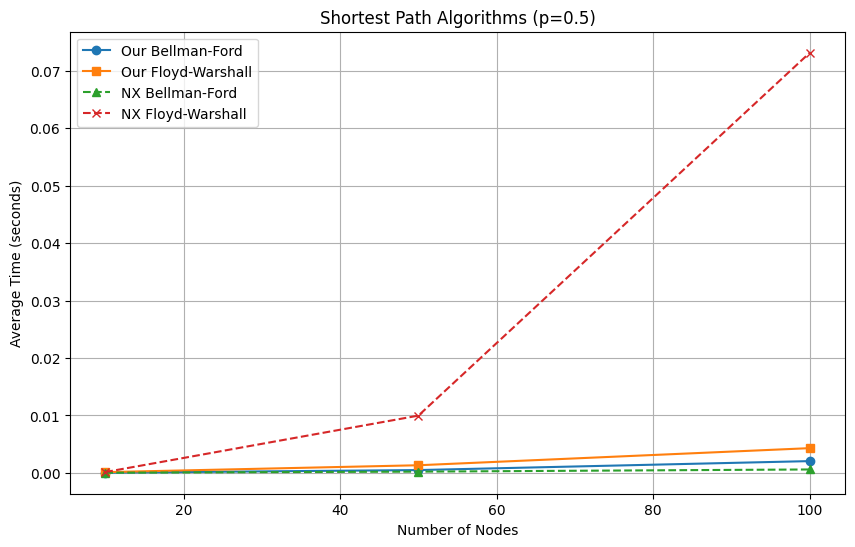

Graph with Negative Cycle (0 -> 1 -> 2 -> 0, weight -2):
DETECTED: Negative cycle detected
DETECTED: Negative cycle detected


In [56]:
NODES = [10, 50, 100]
COMPLETENESS = 0.5
NUM_OF_ITERATIONS = 10
results = []

for N in NODES:
    G = gnp_random_connected_graph(N, COMPLETENESS, True, custom_weights=[0,20])

    source_node = 0

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"NX BF N={N}"):
        start = time.time()
        nx.bellman_ford_predecessor_and_distance(G, source_node)
        end = time.time()
        time_taken += end - start
    avg_nx_bf = time_taken / NUM_OF_ITERATIONS

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"NX FW N={N}"):
        start = time.time()
        nx.floyd_warshall_predecessor_and_distance(G)

        end = time.time()
        time_taken += end - start
    avg_nx_fw = time_taken / NUM_OF_ITERATIONS


    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"BF N={N}"):
        start = time.time()
        Belford(G, source_node)
        end = time.time()
        time_taken += end - start
    avg_bf = time_taken / NUM_OF_ITERATIONS

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"FW N={N}"):
        start = time.time()
        Floyd(G)
        end = time.time()
        time_taken += end - start
    avg_fw = time_taken / NUM_OF_ITERATIONS

    results.append({
        'Nodes': N,
        'Our BF': avg_bf,
        'Our FW': avg_fw,
        'NX BF': avg_nx_bf,
        'NX FW': avg_nx_fw
    })

df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df['Nodes'], df['Our BF'], marker='o', label='Our Bellman-Ford')
plt.plot(df['Nodes'], df['Our FW'], marker='s', label='Our Floyd-Warshall')
plt.plot(df['Nodes'], df['NX BF'], marker='^', linestyle='--', label='NX Bellman-Ford')
plt.plot(df['Nodes'], df['NX FW'], marker='x', linestyle='--', label='NX Floyd-Warshall')

plt.title(f"Shortest Path Algorithms (p={COMPLETENESS})")
plt.xlabel("Number of Nodes")
plt.ylabel("Average Time (seconds)")
plt.legend()
plt.grid(True)
plt.show()


# Behavior with negative cycles
G_neg = nx.DiGraph()
G_neg.add_edges_from([(0, 1, {'weight': 1}),
                      (1, 2, {'weight': -5}),
                      (2, 0, {'weight': 2})]) # 0->1->2->0 sum = -2

print("Graph with Negative Cycle (0 -> 1 -> 2 -> 0, weight -2):")

try:
    Belford(G_neg, 0)
    print("No detection")
except Exception as e:
    print(f"DETECTED: {e}")

try:
    Floyd(G_neg)
    print("No detection")
except Exception as e:
    print(f"DETECTED: {e}")

Алгоритм Белмана-Форда виявився швидшим за Флойда-Воршалла для обох реалізацій

FW N=100: 100%|██████████| 10/10 [00:00<00:00, 204.36it/s]


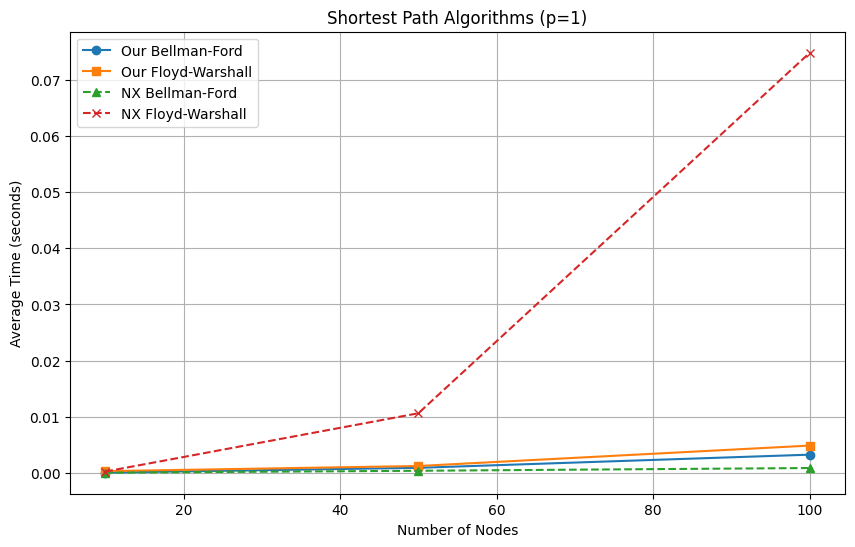

In [57]:
NODES = [10, 50, 100]
COMPLETENESS = 1
NUM_OF_ITERATIONS = 10
results = []

for N in NODES:
    G = gnp_random_connected_graph(N, COMPLETENESS, True, custom_weights=[0,20])

    source_node = 0

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"NX BF N={N}"):
        start = time.time()
        nx.bellman_ford_predecessor_and_distance(G, source_node)
        end = time.time()
        time_taken += end - start
    avg_nx_bf = time_taken / NUM_OF_ITERATIONS

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"NX FW N={N}"):
        start = time.time()
        nx.floyd_warshall_predecessor_and_distance(G)

        end = time.time()
        time_taken += end - start
    avg_nx_fw = time_taken / NUM_OF_ITERATIONS


    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"BF N={N}"):
        start = time.time()
        Belford(G, source_node)
        end = time.time()
        time_taken += end - start
    avg_bf = time_taken / NUM_OF_ITERATIONS

    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS), desc=f"FW N={N}"):
        start = time.time()
        Floyd(G)
        end = time.time()
        time_taken += end - start
    avg_fw = time_taken / NUM_OF_ITERATIONS

    results.append({
        'Nodes': N,
        'Our BF': avg_bf,
        'Our FW': avg_fw,
        'NX BF': avg_nx_bf,
        'NX FW': avg_nx_fw
    })

df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df['Nodes'], df['Our BF'], marker='o', label='Our Bellman-Ford')
plt.plot(df['Nodes'], df['Our FW'], marker='s', label='Our Floyd-Warshall')
plt.plot(df['Nodes'], df['NX BF'], marker='^', linestyle='--', label='NX Bellman-Ford')
plt.plot(df['Nodes'], df['NX FW'], marker='x', linestyle='--', label='NX Floyd-Warshall')

plt.title(f"Shortest Path Algorithms (p={COMPLETENESS})")
plt.xlabel("Number of Nodes")
plt.ylabel("Average Time (seconds)")
plt.legend()
plt.grid(True)
plt.show()


Аналогічно, Белман-Форд швидший за Флойда-Воршалла

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Загальний Підсумок
Алгоритм Белмана-Форда працює значно швидше за алгоритм Флойда-Воршала.
Белман-Форд шукає шлях від однієї вершини ($O(V \cdot E)$) і має механізм ранньої зупинки (якщо на ітерації не відбулося змін — цикл переривається)

Флойд-Воршал обчислює шляхи між усіма парами вершин ($O(V^3)$) і завжди виконує фіксовану кількість операцій, незалежно від того, знайшли ми вже найкоротший шлях чи ні. Навіть із використанням NumPy, кубічна складність робить його значно повільнішим на тестових розмірах графів.

Тому для задачі пошуку шляху від однієї вершини алгоритм Белмана-Форда є кращим порівняно з Флойдом-Воршалом.

# Test Validity

In [58]:
import networkx as nx
import numpy as np

def test():
    G_mst: nx.Graph = gnp_random_connected_graph(20, 0.5, directed=False, custom_weights=[0, 20])

    mst_nx = nx.minimum_spanning_tree(G_mst)
    weight_nx = sum(d['weight'] for _, _, d in mst_nx.edges(data=True))

    try:
        edges_kruskal = Kruskal(G_mst)
        weight_kruskal = sum(w for _, _, w in edges_kruskal)

        if weight_kruskal == weight_nx:
            print(f"Kruskal \033[92mcorrect\033[0m (Total Weight: {weight_kruskal})")
        else:
            print(f"Kruskal \033[91mincorrect\033[0m (Expected {weight_nx}, got {weight_kruskal})")
    except Exception as e:
        print(f"Kruskal raised error: {e}")

    try:
        edges_prim = Prim(G_mst)
        weight_prim = sum(w for _, _, w in edges_prim)

        if weight_prim == weight_nx:
            print(f"Prim \033[92mcorrect\033[0m (Total Weight: {weight_prim})")
        else:
            print(f"Prim \033[91mincorrect\033[0m (Expected {weight_nx}, got {weight_prim})")
    except Exception as e:
        print(f"Prim CRASHED: {e}")

    G_sp = gnp_random_connected_graph(15, 0.5, directed=True, custom_weights=[0,20])
    source = 0


    _, dist_nx = nx.bellman_ford_predecessor_and_distance(G_sp, source)

    try:
        _, dist_bf = Belford(G_sp, source)

        match = True
        for node in G_sp.nodes():
            nx_node = dist_nx.get(node, float('inf'))
            if nx_node == float('inf') and dist_bf[node] == float('inf'):
                continue
            if nx_node != dist_bf[node]:
                match = False
                print(f"\033[91mIncorrect\033[0m node {node}: NX={dist_nx[node]}, OBF={dist_bf[node]}")
                break

        if match:
            print(f"Bellman-Ford \033[92mcorrect\033[0m")
        else:
            print(f"Bellman-Ford \033[91mincorrect\033[0m")

    except Exception as e:
        print(f"Bellman-Ford raised error: {e}")

    try:
        _, dist_nx_fw = nx.floyd_warshall_predecessor_and_distance(G_sp)

        _, dist_fw_matrix = Floyd(G_sp)

        match = True
        nodes = list(G_sp.nodes())
        for u in nodes:
            for v in nodes:
                nx_val = dist_nx_fw[u][v]
                my_val = dist_fw_matrix[u, v]

                if nx_val == float('inf') and my_val == float('inf'):
                    continue
                if nx_val != my_val:
                    match = False
                    print(f"\033[91mincorrect\033[0m node {node}: NX={dist_nx[node]}, OF={dist_bf[node]}")
                    break
            if not match:
                break

        if match:
            print(f"Floyd-Warshall \033[92mcorrect\033[0m")
        else:
            print(f"Floyd-Warshall \033[91mincorrect\033[0m")

    except Exception as e:
        print(f"Floyd-Warshall raised error: {e}")
for _ in range(100):
    print(_, "\n")
    test()

0 

Kruskal correct (Total Weight: 22)
Prim correct (Total Weight: 22)
Bellman-Ford correct
Floyd-Warshall correct
1 

Kruskal correct (Total Weight: 32)
Prim correct (Total Weight: 32)
Bellman-Ford correct
Floyd-Warshall correct
2 

Kruskal correct (Total Weight: 25)
Prim correct (Total Weight: 25)
Bellman-Ford correct
Floyd-Warshall correct
3 

Kruskal correct (Total Weight: 34)
Prim correct (Total Weight: 34)
Bellman-Ford correct
Floyd-Warshall correct
4 

Kruskal correct (Total Weight: 36)
Prim correct (Total Weight: 36)
Bellman-Ford correct
Floyd-Warshall correct
5 

Kruskal correct (Total Weight: 19)
Prim correct (Total Weight: 19)
Bellman-Ford correct
Floyd-Warshall correct
6 

Kruskal correct (Total Weight: 27)
Prim correct (Total Weight: 27)
Bellman-Ford correct
Floyd-Warshall correct
7 

Kruskal correct (Total Weight: 26)
Prim correct (Total Weight: 26)
Bellman-Ford correct
Floyd-Warshall correct
8 

Kruskal correct (Total Weight: 35)
Prim correct (Total Weight: 35)
Bellman-F

# Useful explanations

### How to get list of edges for your algorithm


In [59]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [60]:
edges[:5]

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

### To get edges with weights

In [61]:
edges = list(G.edges(data=True))

In [62]:
edges[:5]

[(0, 1, {'weight': 5}),
 (0, 2, {'weight': 3}),
 (0, 3, {'weight': 20}),
 (0, 4, {'weight': 17}),
 (0, 5, {'weight': 6})]

In [63]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


### Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [64]:
import time
from tqdm import tqdm

In [65]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):

    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)

    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()

    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 261.56it/s]


0.0011329903602600097

# Task 2. Decision Tree Classifier

In [66]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn import tree
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import typing as npt
import pandas as pd
import matplotlib.pyplot as plt

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## General idea


You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://medium.com/data-science/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575

Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Dataset

You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set

However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.

P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

In [ ]:
# Load dataset
iris = load_iris()
dir(iris)

In [ ]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [ ]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

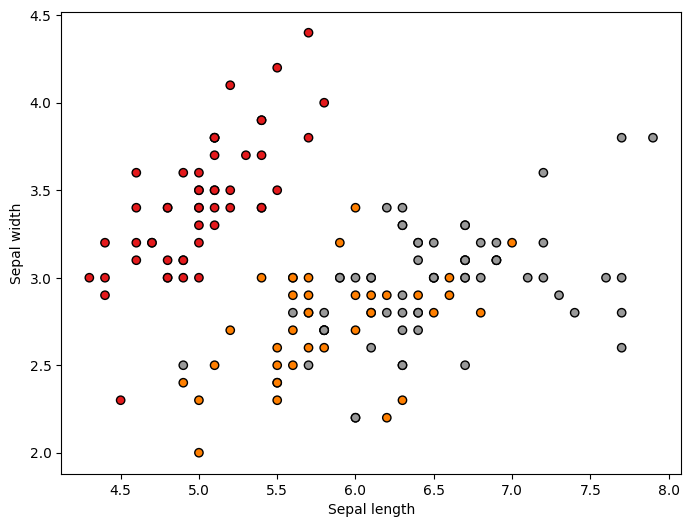

In [ ]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage

**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [ ]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [ ]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris")

'iris.pdf'

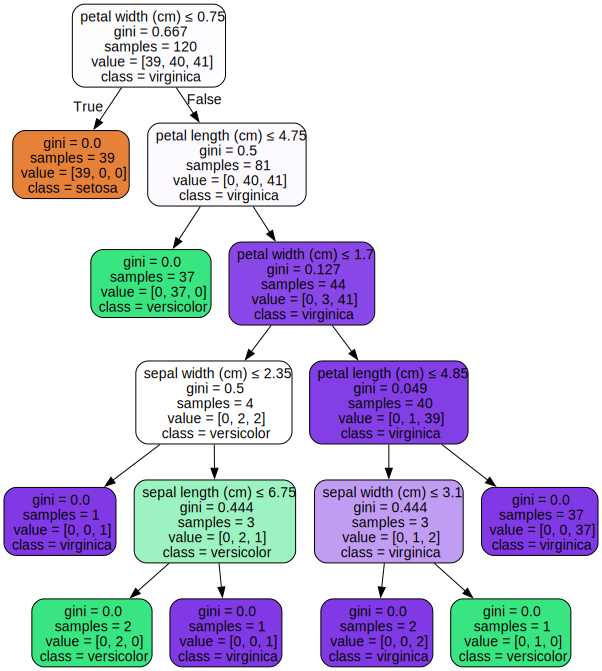

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=iris.feature_names,
                     class_names=iris.target_names,
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [ ]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [ ]:
sum(predictions == y_test) / len(y_test)

np.float64(0.8)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [ ]:
y_test

array([2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 1, 2, 1, 1, 1, 0, 2, 1, 0, 1, 0, 0,
       1, 2, 1, 0, 1, 1, 0, 2])


Here you can traverse the tree above by yourself and make sure that prediction works

In [ ]:
X_test[1]

array([4.9, 3.1, 1.5, 0.2])

In [ ]:
clf.predict([X_test[1]])

array([0])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Decision tree classifier (2 point)

###  Gini impurity


Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$


### Your implementation

> We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.

In [68]:
from ucimlrepo import fetch_ucirepo # for my dataset
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import typing as npt


class Node:
    def __init__(self, predicted_class):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None


In [69]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None


    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = len(np.unique(y))
        self.tree = self.grow_tree(X, y)


    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it
        """
        return [self.predict_one(sample) for sample in X_test]

    def gini(self, y):
        """
        Calculate Gini Impurity: 1 - sum(probabilities^2)
        """
        rows = len(y)
        if rows == 0:
            return 0

        # Count occurrencies of each class
        counts = np.bincount(y) if np.issubdtype(y.dtype, np.integer) else np.unique(y, return_counts=True)[1]
        probabilities = counts / rows
        return 1 - np.sum(probabilities ** 2)

    def best_split(self, X, y):
        """
        Find the best feature and threshold to spit the data
        """
        rows, cols = X.shape
        if rows <= 1:
            return None, None

        best_gini = 1.0
        best_idx, best_thr = None, None

        for idx in range(cols):
            # sorting unique value to find potential thresholds
            thresholds = np.unique(X[:, idx])

            for thr in thresholds:
                #creating boolean mask for split
                left_mask = X[:, idx] < thr

                # if split doesnt divide, just skip
                if np.sum(left_mask) == 0 or np.sum(left_mask) == rows:
                    continue

                y_left = y[left_mask]
                y_right = y[~left_mask]

                # calculating gini

                gini_left = self.gini(y_left)
                gini_right = self.gini(y_right)
                weighted_gini = (len(y_left) / rows) * gini_left + (len(y_right) / rows) * gini_right

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_idx = idx
                    best_thr = thr
        return best_idx, best_thr

    def grow_tree(self, X, y, depth=0):
        """
        Recursive function to build the tree nodes.
        """
        predicted_class = np.argmax(np.bincount(y) if len(y) > 0 else 0)
        node = Node(predicted_class=predicted_class)

        # stopping criteria
        if len(np.unique(y)) == 1:
            return node
        if self.max_depth is not None and depth >= self.max_depth:
            return node

        # looking for best split
        idx, thr = self.best_split(X, y)

        if idx is not None:
            node.feature_index = idx
            node.threshold = thr

            # spliting data
            left_indices = X[:, idx] < thr
            X_left, y_left = X[left_indices], y[left_indices]
            X_right, y_right = X[~left_indices], y[~left_indices]

            # recursive
            node.left = self.grow_tree(X_left, y_left, depth=depth+1)
            node.right = self.grow_tree(X_right, y_right, depth=depth+1)
        return node

    def predict_one(self, sample):
        """
        Predict class for a single sample by traversing the tree.
        """
        node = self.tree
        while node.left:
            if sample[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right

        return node.predicted_class

In [70]:
def evaluate(X_test, y_test, model):
    """
    Returns accuracy of the model.
    """
    predictions = model.predict(X_test)
    y_test_flat = y_test.flatten() if hasattr(y_test, 'flatten') else y_test

    correct = np.sum(predictions == y_test_flat)
    return correct / len(y_test)

Fetching and dividing data

In [71]:
print("--- 1. Fetching Dataset ---")
phishing_websites = fetch_ucirepo(id=327) # loading dataset with phishing websites from UCI ML Repo

X = phishing_websites.data.features.values
y = phishing_websites.data.targets.values

y = y.reshape(-1)
y = y.copy()
y[y == -1] = 0 # changing -1 to 0 for binary classification

print(f"Data loaded. Features shape: {X.shape}, Target shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


--- 1. Fetching Dataset ---
Data loaded. Features shape: (11055, 30), Target shape: (11055,)


Training Tree

In [72]:
print("\n--- 2. Training Custom Decision Tree ---")
my_model = DecisionTreeClassifier(max_depth=3)
my_model.fit(X_train, y_train)
print("Training complete.")


--- 2. Training Custom Decision Tree ---
Training complete.


Evaluation

In [73]:
print("\n--- 3. Evaluation ---")
accuracy = evaluate(X_test, y_test, my_model)

print(f"Model Accuracy on Test Set: {accuracy * 100:.2f}%")


--- 3. Evaluation ---
Model Accuracy on Test Set: 91.41%


Comparison with Sklearn

In [74]:
print("\n--- Comparison with Sklearn ---")
from sklearn.tree import DecisionTreeClassifier as SklearnDTC
sk_model = SklearnDTC(max_depth=3, criterion='gini')
sk_model.fit(X_train, y_train)
sk_acc = sk_model.score(X_test, y_test)
print(f"Sklearn Accuracy: {sk_acc * 100:.2f}%")


--- Comparison with Sklearn ---
Sklearn Accuracy: 91.41%


#### Additional point (+0.5)

Use Laplace smoothing, explain what is the point of using it